In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

In [29]:
# Read Data from CSV
path = "/home/aisha/Documents/ignite_data.csv"
df = pd.read_csv(path, encoding = 'utf-8')

In [30]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,class
0,16,128,415,2845,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [31]:
# Adding new columns:

df['total_local_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
df['total_local_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']
df['total_local_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']
df['average_charge_per_local_call'] = df['total_local_charge'] / df['total_local_calls']
df['average_local_call_duration_in_minutes'] = df['total_local_minutes'] / df['total_local_calls']
df['average_charge_per_intl_call'] = df['total_intl_charge'] / df['total_intl_calls']
df['average_intl_call_duration_in_minutes'] = df['total_intl_minutes'] / df['total_intl_calls']

In [32]:
# Dropping unneccessary columns:

df = df.drop(['total_day_minutes' , 'total_eve_minutes' , 'total_night_minutes', 'total_day_calls' , 'total_eve_calls', 'total_night_calls' ,'total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

In [33]:
# Split Data

# Extract the labels
labels = np.array(df.pop('class'))

# 20% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.2, 
                                         random_state = 0)
# Fill missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [34]:
# Logistic Regression 

from sklearn.linear_model import LogisticRegression

logistic_regression= LogisticRegression()
logistic_regression.fit(train,train_labels)
pred=logistic_regression.predict(test)

print('Accuracy: ', metrics.accuracy_score(test_labels, pred))

Accuracy:  0.861


/home/aisha/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
# Decision Tree:

from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=0)
# tree.fit(X, y)

# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

#print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Decision tree has 345 nodes with maximum depth 24.
Test ROC AUC  Score: 0.9109801104698684


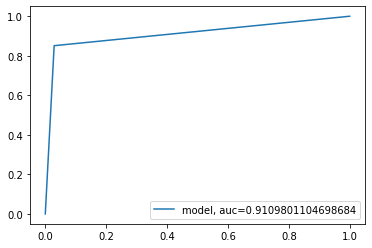

In [43]:
fpr, tpr, _ = metrics.roc_curve(test_labels,  probs)
auc = metrics.roc_auc_score(test_labels, probs)

plt.plot(fpr,tpr,label="model, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [36]:
# Random Forests:

from sklearn.ensemble import RandomForestClassifier

# Features for feature importances
# features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(train, train_labels)

n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Actual class predictions
rf_predictions = model.predict(test)
# Probabilities for each class
rf_probs = model.predict_proba(test)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs)
print('Test ROC AUC Score: ', roc_value)

Average number of nodes 394
Average maximum depth 20
Test ROC AUC Score:  0.9320461694696951


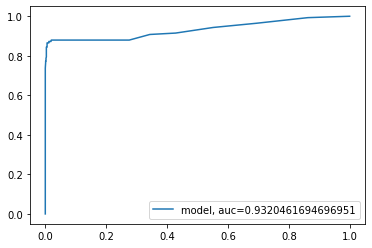

In [42]:
fpr, tpr, _ = metrics.roc_curve(test_labels,  rf_probs)
auc = metrics.roc_auc_score(test_labels, rf_probs)

plt.plot(fpr,tpr,label="model, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [46]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
13,total_local_charge,0.263165
10,number_customer_service_calls,0.117336
4,international_plan,0.100967
11,total_local_minutes,0.078987
14,average_charge_per_local_call,0.053185
